In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from textblob import TextBlob

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Input, Layer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")


# NLP (kept only to mirror your original structure)
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

# Models / ML utils
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix,
    precision_score, recall_score, f1_score, balanced_accuracy_score, make_scorer
)
from sklearn.base import clone
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit
# Repro
RND = 42
np.random.seed(RND)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving upload_DJIA_table.csv to upload_DJIA_table.csv


In [ ]:
df=pd.read_csv("Combined_News_DJIA.csv")
dj=pd.read_csv("upload_DJIA_table.csv")

In [ ]:
# Combine news headlines as one column
df["combined news"]=df.loc[:,"Top1":"Top25"].astype(str).agg(" ".join,axis=1)

In [ ]:
#cleaning the text column
# Convert text to lowercase and remove unwanted characters, links, and punctuation

stop = set(stopwords.words("english"))   #Load a list of common English stopwords
lemmatizer = WordNetLemmatizer()   #Load a lemmatizer, which reduces words to their root form

def clean_text(text):
    text = re.sub(r"b[\"']", " ", str(text).lower())
    text = re.sub(r"\[.*?\]\(.*?\)", "", text)
    text = re.sub(r"[^\w\s]", " ", text)  ## remove punctuation
    text = re.sub(r"\s+", " ", text)  # remove extra whitespace
    tokens = word_tokenize(text)    # tokenize into words (Tokenize each headline into individual words)
    output = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop] # Lemmatize words to reduce them to their base form
    return " ".join(output)

# we apply a clean_text function to every row in the combined news
df["clean text"]=df["combined news"].apply(clean_text)

In [ ]:
#merge the news dataset and stock price dataset
df_merged=pd.merge(df,dj,on="Date",how="inner")

In [ ]:
# Download and install vaderSentiment library for sentiment analysis
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.4 MB/s eta 0:00:00


In [ ]:
# Import the VADER sentiment analyzer class
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Create a sentiment analyzer object
analyse = SentimentIntensityAnalyzer()

# Compute the sentiment polarity scores for the 2nd entry in the "clean text" column
analyse.polarity_scores(df["clean text"][1])

{'neg': 0.284, 'neu': 0.613, 'pos': 0.103, 'compound': -0.9895}

In [ ]:
# define a function to apply VADER sentiment analysis to any given text
def get_sentiment(text):
    return analyse.polarity_scores(str(text))

In [ ]:
#  function to extract sentiment features from  VADER


def getSIA(text):
    sia = SentimentIntensityAnalyzer()      # Create a new SentimentIntensityAnalyzer object
    sentiment= sia.polarity_scores(text)    # Generate polarity sentiment scores
    return sentiment                        # Return the dictionary containing sentiment results

In [ ]:
# Extract VADER sentiment scores for each cleaned text(each day)
# We compute the four VADER metrics: compound, neg, pos, and neu

compound = []
neg = []
pos = []
neu = []

# Loop through all rows in the "clean text" column
for i in range(len(df["clean text"])):
    # Get the sentiment score dictionary for the current text
    SIA = get_sentiment(df["clean text"].iloc[i])

    # Append each score type to its respective list
    compound.append(SIA["compound"])
    neg.append(SIA["neg"])
    pos.append(SIA["pos"])
    neu.append(SIA["neu"])

# Add the sentiment scores back into the dataframe as separate columns
df["compound"] = compound
df["neg"] = neg
df["pos"] = pos
df["neu"] = neu


In [ ]:
# Assign the calculated sentiment values to the merged dataframe as new columns
df_merged["compound"] = compound   # overall normalized sentiment score
df_merged["neg"] = neg             # negative sentiment proportion
df_merged["pos"] = pos             # positive sentiment proportion
df_merged["neu"] = neu             # neutral sentiment proportion


In [ ]:
df_merged.columns

Index(['Date', 'Label', 'Top1', 'Top2', 'Top3', 'Top4', 'Top5', 'Top6', 'Top7',
       'Top8', 'Top9', 'Top10', 'Top11', 'Top12', 'Top13', 'Top14', 'Top15',
       'Top16', 'Top17', 'Top18', 'Top19', 'Top20', 'Top21', 'Top22', 'Top23',
       'Top24', 'Top25', 'combined news', 'clean text', 'Open', 'High', 'Low',
       'Close', 'Volume', 'Adj Close', 'compound', 'neg', 'pos', 'neu'],
      dtype='object')

In [ ]:
df_merged.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Open,High,Low,Close,Volume,Adj Close,compound,neg,pos,neu
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,-0.9971,0.287,0.067,0.646
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609,-0.9895,0.284,0.103,0.613
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727,-0.9942,0.259,0.091,0.650
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961,-0.9712,0.199,0.104,0.697
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree to missle defense deal. ...,"b'Will the Russians conquer Tblisi? Bet on it,...",...,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688,-0.9855,0.249,0.131,0.620


In [ ]:
# Create a copy of df_merged
df = df_merged.copy()

# Convert the 'Date' column to datetime format, coercing invalid values to NaT
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# Sort the dataframe by date and reset the index
df = df.sort_values("Date").reset_index(drop=True)


#Classification


In [ ]:
df.columns

Index(['Date', 'Label', 'Top1', 'Top2', 'Top3', 'Top4', 'Top5', 'Top6', 'Top7',
       'Top8', 'Top9', 'Top10', 'Top11', 'Top12', 'Top13', 'Top14', 'Top15',
       'Top16', 'Top17', 'Top18', 'Top19', 'Top20', 'Top21', 'Top22', 'Top23',
       'Top24', 'Top25', 'combined news', 'clean text', 'Open', 'High', 'Low',
       'Close', 'Volume', 'Adj Close', 'compound', 'neg', 'pos', 'neu'],
      dtype='object')

In [ ]:

need_cols = ['Open', 'High', 'Low','Close', 'Volume', 'Adj Close', 'compound','neg', 'pos', 'neu']

for c in need_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=["Date", "Adj Close"]).reset_index(drop=True)

In [ ]:
# Technical indicators
def rsi(series, n=14):
    d = series.diff()
    up = d.clip(lower=0).rolling(n).mean()
    dn = (-d.clip(upper=0)).rolling(n).mean()
    rs = up / (dn + 1e-12)
    return 100 - 100/(1+rs)

def macd(series, fast=12, slow=26, signal=9):
    ema_f = series.ewm(span=fast, adjust=False).mean()
    ema_s = series.ewm(span=slow, adjust=False).mean()
    line = ema_f - ema_s
    sig  = line.ewm(span=signal, adjust=False).mean()
    return line, sig, line - sig

In [ ]:

px = pd.to_numeric(df["Adj Close"], errors="coerce")
rsi14 = rsi(px, 14)
macd_line, macd_sig, macd_hist = macd(px)

df["rsi14"] = rsi14
df["macd_line"] = macd_line
df["macd_signal"] = macd_sig
df["macd_hist"] = macd_hist

In [ ]:

# Day-of-week dummies
df["dow"] = df["Date"].dt.dayofweek.astype(float)
dow_dummies = pd.get_dummies(df["dow"], prefix="dow").astype(int)

# ensure dow_0.0 ... dow_4.0 exist
for i in range(5):
    col = f"dow_{i}.0"
    if col not in dow_dummies.columns:
        dow_dummies[col] = 0

dow_dummies = dow_dummies[[f"dow_{i}.0" for i in range(5)]]

df = pd.concat([df, dow_dummies], axis=1)
df = df.drop(columns=["dow"])

In [ ]:
df.columns

Index(['Date', 'Label', 'Top1', 'Top2', 'Top3', 'Top4', 'Top5', 'Top6', 'Top7',
       'Top8', 'Top9', 'Top10', 'Top11', 'Top12', 'Top13', 'Top14', 'Top15',
       'Top16', 'Top17', 'Top18', 'Top19', 'Top20', 'Top21', 'Top22', 'Top23',
       'Top24', 'Top25', 'combined news', 'clean text', 'Open', 'High', 'Low',
       'Close', 'Volume', 'Adj Close', 'compound', 'neg', 'pos', 'neu',
       'rsi14', 'macd_line', 'macd_signal', 'macd_hist', 'dow_0.0', 'dow_1.0',
       'dow_2.0', 'dow_3.0', 'dow_4.0'],
      dtype='object')

In [ ]:
# -------------------
# FEATURES: (Close removed)
# -------------------
features = ['Open', 'High', 'Low','Volume', 'compound',
       'neg', 'pos', 'neu','rsi14', 'macd_line', 'macd_signal', 'macd_hist',
       'dow_0.0', 'dow_1.0', 'dow_2.0', 'dow_3.0', 'dow_4.0']

# Drop rows with NaNs in features or label (prevents sklearn error)
df = df.dropna(subset=features + ['Label']).reset_index(drop=True)

X = df[features]
y = df['Label'].astype(int)


In [ ]:

# Split by date
split_date = "2015-01-01"
X_train = X[df["Date"] < split_date]
y_train = y[df["Date"] < split_date]

X_test = X[df["Date"] >= split_date]
y_test = y[df["Date"] >= split_date]

In [ ]:
# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [ ]:
# models (kept as you had them)
model_params = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000),
        "params": {"C": [0.01, 0.1, 1, 10, 100], "solver": ["liblinear", "lbfgs"]}
    },
    "Naive Bayes": {
        "model": GaussianNB(),
        "params": {}
    },
    "SVM": {
        "model": svm.SVC(),
        "params": {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"], "gamma": ["scale", "auto"]}
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {"n_neighbors": [3,5,7,11,15], "weights": ["uniform", "distance"]}
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        "params": {"n_estimators": [100, 200], "max_depth": [3, 5, 7], "learning_rate": [0.01, 0.1]}
    },
    "Random Forest": {
        "model": RandomForestClassifier(),
        "params": {"n_estimators": [100, 200], "max_depth": [None, 5, 10], "max_features": ["sqrt", "log2", None]}
    },
    "LDA": {
        "model": LinearDiscriminantAnalysis(),
        "params": {"solver": ["svd", "lsqr", "eigen"]}
    }
}

In [ ]:

cv = TimeSeriesSplit(n_splits=5)
#cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

# Loop through models
for name, mp in model_params.items():
    model = mp["model"]
    params = mp["params"]

    # --- Training (Same as your original code) ---
    if params:
        grid = GridSearchCV(model, params, cv=cv, scoring="accuracy", n_jobs=-1)
        grid.fit(X_train_scaled, y_train)
        best_model = grid.best_estimator_
        best_params = grid.best_params_
    else:
        best_model = model
        best_model.fit(X_train_scaled, y_train)
        best_params = "None"

    # --- Standard Predictions ---
    y_pred_train = best_model.predict(X_train_scaled)
    y_pred_test = best_model.predict(X_test_scaled)

    # --- NEW: AUC Calculation Logic ---
    try:
        # Check if model has probability prediction (e.g., Random Forest, XGBoost, Logistic Reg)
        if hasattr(best_model, "predict_proba"):
            # Get probability of the positive class (Class 1)
            y_scores = best_model.predict_proba(X_test_scaled)[:, 1]

        # Check if model has decision function (e.g., SVM, LDA)
        elif hasattr(best_model, "decision_function"):
            y_scores = best_model.decision_function(X_test_scaled)

        else:
            # Fallback for models with neither (rare)
            y_scores = y_pred_test

        # Calculate AUC
        auc_score = roc_auc_score(y_test, y_scores)

    except Exception as e:
        print(f"Could not calculate AUC for {name}: {e}")
        auc_score = 0.5 # Default to random guessing score if error occurs

    # --- Calculate Other Metrics ---
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test  = accuracy_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test, average="weighted", zero_division=0)
    recall = recall_score(y_test, y_pred_test, average="weighted", zero_division=0)
    f1 = f1_score(y_test, y_pred_test, average="weighted", zero_division=0)

    # --- Append to Results ---
    results.append({
        "Model": name,
        "Best Params": best_params,
        "Train Accuracy": round(acc_train, 4),
        "Test Accuracy": round(acc_test, 4),
        "AUC Score": round(auc_score, 4),       # <--- Added AUC here
        "Precision": round(precision, 4),
        "Recall": round(recall, 4),
        "F1 Score": round(f1, 4)
    })

# --- Display Final Results ---
results_df = pd.DataFrame(results).sort_values(by="AUC Score", ascending=False)
print(results_df)

                 Model                                        Best Params  \
0  Logistic Regression                  {'C': 100, 'solver': 'liblinear'}   
6                  LDA                                  {'solver': 'svd'}   
2                  SVM    {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}   
4              XGBoost  {'learning_rate': 0.01, 'max_depth': 5, 'n_est...   
5        Random Forest  {'max_depth': 5, 'max_features': 'log2', 'n_es...   
1          Naive Bayes                                               None   
3                  KNN          {'n_neighbors': 11, 'weights': 'uniform'}   

   Train Accuracy  Test Accuracy  AUC Score  Precision  Recall  F1 Score  
0          0.8635         0.8783     0.9484     0.8785  0.8783    0.8783  
6          0.8585         0.8757     0.9476     0.8757  0.8757    0.8756  
2          0.8547         0.8624     0.9435     0.8629  0.8624    0.8624  
4          0.7621         0.6005     0.6238     0.6086  0.6005    0.5902  
5       

In [ ]:


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

for name, mp in model_params.items():
    model = mp["model"]
    params = mp["params"]

    if params:
        grid = GridSearchCV(model, params, cv=cv, scoring="accuracy", n_jobs=-1)
        grid.fit(X_train_scaled, y_train)
        best_model = grid.best_estimator_
        best_params = grid.best_params_
    else:
        best_model = model
        best_model.fit(X_train_scaled, y_train)
        best_params = "None"

    y_pred_train = best_model.predict(X_train_scaled)
    y_pred_test = best_model.predict(X_test_scaled)

    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test  = accuracy_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test, average="weighted", zero_division=0)
    recall = recall_score(y_test, y_pred_test, average="weighted", zero_division=0)
    f1 = f1_score(y_test, y_pred_test, average="weighted", zero_division=0)

    results.append({
        "Model": name,
        "Best Params": best_params,
        "Train Accuracy": round(acc_train, 4),
        "Test Accuracy": round(acc_test, 4),
        "Precision": round(precision, 4),
        "Recall": round(recall, 4),
        "F1 Score": round(f1, 4)
    })

results_df = pd.DataFrame(results).sort_values(by="Test Accuracy", ascending=False)
print(results_df)


                 Model                                        Best Params  \
0  Logistic Regression                  {'C': 100, 'solver': 'liblinear'}   
6                  LDA                                  {'solver': 'svd'}   
2                  SVM    {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}   
5        Random Forest  {'max_depth': 5, 'max_features': 'log2', 'n_es...   
4              XGBoost  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...   
1          Naive Bayes                                               None   
3                  KNN          {'n_neighbors': 15, 'weights': 'uniform'}   

   Train Accuracy  Test Accuracy  Precision  Recall  F1 Score  
0          0.8635         0.8783     0.8785  0.8783    0.8783  
6          0.8585         0.8757     0.8757  0.8757    0.8756  
2          0.8547         0.8624     0.8629  0.8624    0.8624  
5          0.6913         0.5714     0.5761  0.5714    0.5607  
4          0.8641         0.5714     0.5829  0.5714    0.5508  

#Regression

In [ ]:
#Regression

# ==========================
# Fix randomness - MUST BE AT THE VERY TOP
# ==========================
import os
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Set all random seeds
random.seed(42)
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
df=pd.read_csv("Combined_News_DJIA.csv")
dj=pd.read_csv("upload_DJIA_table.csv")

In [ ]:
# Combine news headlines as one column
df["combined news"]=df.loc[:,"Top1":"Top25"].astype(str).agg(" ".join,axis=1)

In [ ]:
#cleaning the text column
# Convert text to lowercase and remove unwanted characters, links, and punctuation

stop = set(stopwords.words("english"))   #Load a list of common English stopwords
lemmatizer = WordNetLemmatizer()   #Load a lemmatizer, which reduces words to their root form

def clean_text(text):
    text = re.sub(r"b[\"']", " ", str(text).lower())
    text = re.sub(r"\[.*?\]\(.*?\)", "", text)
    text = re.sub(r"[^\w\s]", " ", text)  ## remove punctuation
    text = re.sub(r"\s+", " ", text)  # remove extra whitespace
    tokens = word_tokenize(text)    # tokenize into words (Tokenize each headline into individual words)
    output = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop] # Lemmatize words to reduce them to their base form
    return " ".join(output)

# we apply a clean_text function to every row in the combined news
df["clean text"]=df["combined news"].apply(clean_text)

In [ ]:
#merge the news dataset and stock price dataset
df_merged=pd.merge(df,dj,on="Date",how="inner")

In [ ]:
# Download and install vaderSentiment library for sentiment analysis
!pip install vaderSentiment

In [ ]:
# Import the VADER sentiment analyzer class
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Create a sentiment analyzer object
analyse = SentimentIntensityAnalyzer()

# Compute the sentiment polarity scores for the 2nd entry in the "clean text" column
analyse.polarity_scores(df["clean text"][1])

{'neg': 0.284, 'neu': 0.613, 'pos': 0.103, 'compound': -0.9895}

In [ ]:
# define a function to apply VADER sentiment analysis to any given text
def get_sentiment(text):
    return analyse.polarity_scores(str(text))

In [ ]:
#  function to extract sentiment features from  VADER


def getSIA(text):
    sia = SentimentIntensityAnalyzer()      # Create a new SentimentIntensityAnalyzer object
    sentiment= sia.polarity_scores(text)    # Generate polarity sentiment scores
    return sentiment                        # Return the dictionary containing sentiment results

In [ ]:
# Extract VADER sentiment scores for each cleaned text(each day)
# We compute the four VADER metrics: compound, neg, pos, and neu

compound = []
neg = []
pos = []
neu = []

# Loop through all rows in the "clean text" column
for i in range(len(df["clean text"])):
    # Get the sentiment score dictionary for the current text
    SIA = get_sentiment(df["clean text"].iloc[i])

    # Append each score type to its respective list
    compound.append(SIA["compound"])
    neg.append(SIA["neg"])
    pos.append(SIA["pos"])
    neu.append(SIA["neu"])

# Add the sentiment scores back into the dataframe as separate columns
df["compound"] = compound
df["neg"] = neg
df["pos"] = pos
df["neu"] = neu


In [ ]:
# Assign the calculated sentiment values to the merged dataframe as new columns
df_merged["compound"] = compound   # overall normalized sentiment score
df_merged["neg"] = neg             # negative sentiment proportion
df_merged["pos"] = pos             # positive sentiment proportion
df_merged["neu"] = neu             # neutral sentiment proportion


In [ ]:
df_merged.columns

Index(['Date', 'Label', 'Top1', 'Top2', 'Top3', 'Top4', 'Top5', 'Top6', 'Top7',
       'Top8', 'Top9', 'Top10', 'Top11', 'Top12', 'Top13', 'Top14', 'Top15',
       'Top16', 'Top17', 'Top18', 'Top19', 'Top20', 'Top21', 'Top22', 'Top23',
       'Top24', 'Top25', 'combined news', 'clean text', 'Open', 'High', 'Low',
       'Close', 'Volume', 'Adj Close', 'compound', 'neg', 'pos', 'neu'],
      dtype='object')

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.0336 - val_loss: 0.0035
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0025 - val_loss: 9.4668e-04
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0019 - val_loss: 0.0056
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 0.0026 - val_loss: 5.8079e-04
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0017 - val_loss: 8.7857e-04
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0017 - val_loss: 9.6327e-04
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0019 - val_loss: 5.7946e-04
Epoch 12/200
44/44 ━━━━━━━━━━━

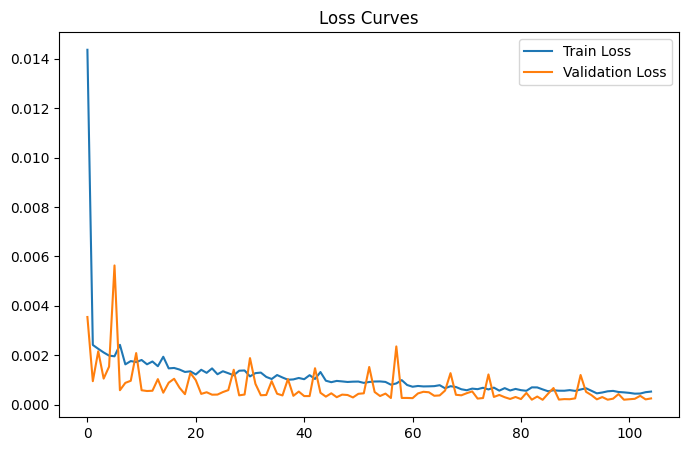

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
✅ Train R²: 0.997267522273974
✅ Test  R²: 0.8381878669868411


In [ ]:

# Ensure numeric & datetime
df_merged["Date"] = pd.to_datetime(df_merged["Date"], errors="coerce")
for c in ['compound', 'neg', 'pos', 'neu', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']:
    df_merged[c] = pd.to_numeric(df_merged[c], errors="coerce")

# ==========================
# Technical indicators
# ==========================
px = df_merged["Adj Close"]

# Returns
df_merged["ret1"] = px.pct_change(1)
df_merged["ret5"] = px.pct_change(5)
df_merged["ret10"] = px.pct_change(10)

# Volatility
df_merged["vol10"] = df_merged["ret1"].rolling(10).std()
df_merged["vol20"] = df_merged["ret1"].rolling(20).std()

# RSI
def rsi(series, n=14):
    d = series.diff()
    up = d.clip(lower=0).rolling(n).mean()
    dn = (-d.clip(upper=0)).rolling(n).mean()
    rs = up / dn.replace(0, 1e-12)
    return 100 - (100 / (1 + rs))
df_merged["RSI14"] = rsi(px, 14)

# MACD
ema12 = px.ewm(span=12, adjust=False).mean()
ema26 = px.ewm(span=26, adjust=False).mean()
df_merged["MACD"] = ema12 - ema26
df_merged["MACDsig"] = df_merged["MACD"].ewm(span=9, adjust=False).mean()
df_merged["MACDhist"] = df_merged["MACD"] - df_merged["MACDsig"]

# Day-of-week dummies
df_merged["dow"] = df_merged["Date"].dt.dayofweek.astype(int)
dow_dummies = pd.get_dummies(df_merged["dow"], prefix="dow").astype(int)
for i in range(5):
    col = f"dow_{i}"
    if col not in dow_dummies.columns:
        dow_dummies[col] = 0
dow_dummies = dow_dummies[[f"dow_{i}" for i in range(5)]]
df_merged = pd.concat([df_merged, dow_dummies], axis=1)
df_merged = df_merged.drop(columns=["dow"])

# ==========================
# Features & target
# ==========================
base_features = ['compound', 'neg', 'pos', 'neu', 'Open', 'High', 'Low', 'Close', 'Volume']
tech_features = ["ret1","ret5","ret10","vol10","vol20","RSI14","MACD","MACDsig","MACDhist",
                 "dow_0","dow_1","dow_2","dow_3","dow_4"]
features = base_features + tech_features

# Next-day target
#df_merged["AdjClose_next"] = df_merged["Adj Close"].shift(-1)
#target = "AdjClose_next"
target="Adj Close"
# Drop rows with NaNs
df_merged = df_merged.dropna(subset=features + [target]).reset_index(drop=True)

# ==========================
# Train/test split
# ==========================
train = df_merged[df_merged['Date'] < '2015-01-01']
test = df_merged[df_merged['Date'] >= '2015-01-01']

X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train = X_scaler.fit_transform(train[features])
y_train = y_scaler.fit_transform(train[[target]])

X_test = X_scaler.transform(test[features])
y_test = y_scaler.transform(test[[target]])

SEQ_LEN = 30

def create_sequences(X, y, seq_len=SEQ_LEN):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train, y_train)
X_test_seq, y_test_seq = create_sequences(X_test, y_test)

# ==========================
# LSTM model
# ==========================
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(SEQ_LEN, X_train_seq.shape[2])),
    Dropout(0.1),
    LSTM(64, return_sequences=True),
    Dropout(0.1),
    LSTM(32),
    Dropout(0.1),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse')

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=200,
    batch_size=32,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)],
    verbose=1
)

# ==========================
# Prediction
# ==========================
y_pred_scaled = model.predict(X_test_seq)
y_pred_inv = y_scaler.inverse_transform(y_pred_scaled)
y_test_inv = y_scaler.inverse_transform(y_test_seq)

# ==========================
# Metrics
# ==========================
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

# ==========================
# Loss curves
# ==========================
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

# ==========================
# Train & Test R²
# ==========================
train_preds_scaled = model.predict(X_train_seq)
train_pred_inv = y_scaler.inverse_transform(train_preds_scaled)
train_true_inv = y_scaler.inverse_transform(y_train_seq)

test_pred_scaled = model.predict(X_test_seq)
test_pred_inv = y_scaler.inverse_transform(test_pred_scaled)
test_true_inv = y_scaler.inverse_transform(y_test_seq)

print("✅ Train R²:", r2_score(train_true_inv, train_pred_inv))
print("✅ Test  R²:", r2_score(test_true_inv, test_pred_inv))